In [1]:
import pandas as pd
import openai
import json
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for the progress bar


In [2]:
#pip install openai

In [3]:
from openai import OpenAI

In [4]:
openai.__version__


'1.1.1'

### Read in data

In [5]:
# Initialize an empty list to store the parsed data
data_list = []

# Read the JSONL file line by line
with open('../data/prodigy/annotated_output/pilot_500_pubmed_abstracts_shirin_correct_id.jsonl', 'r') as file:
    for line in file:
        # Parse each line as a JSON object
        data = json.loads(line.strip())
        
        # Check if _view_id is "choice"// should be review if this was coming from a review prodigy session
        if data.get("_view_id") == "choice":
            # Split text into journal_name, title, and abstract based on ^\n symbol
            text = data.get("text", "")
            
            # Splitting text based on ^\n for journal_name, title, and abstract
            parts = text.split("^\n", 2)  # Split into three parts based on first two ^\n occurrences
            
            journal_name = parts[0].strip() if len(parts) > 0 else ""
            title = parts[1].strip() if len(parts) > 1 else ""
            abstract = parts[2].strip() if len(parts) > 2 else ""
            
            # Extract other required fields
            pmid = data.get("pmid", "")
            accept = data.get("accept", [])
            
            # Append to the list
            data_list.append({
                "pmid": pmid,
                "journal_name": journal_name,
                "title": title,
                "abstract": abstract,
                "accepted_label": accept
            })

# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data_list)

In [6]:
df.head(5)

,pmid,journal_name,title,abstract,accepted_label
0,37550718,Trials,Can dexamethasone improve postoperative sleep ...,Perioperative sleep disorders (PSD) are an ind...,[Human-RCT-drug-intervention]
1,2500373,Developmental medicine and child neurology,Effects of puberty on seizure frequency.,"Seizure frequency was documented before, durin...",[Remaining]
2,36189588,Journal of Alzheimer's disease : JAD,Characterization of Mild Cognitive Impairment ...,"Despite tremendous advancements in the field, ...",[Remaining]
3,36314672,Journal of vector ecology : journal of the Soc...,Effects of woody plant encroachment by eastern...,Woody plant encroachment into grasslands is oc...,[Remaining]
4,29172241,Depression and anxiety,The impact of resilience and subsequent stress...,There remains a dearth of research examining t...,[Remaining]


### Load key for the OpenAI API 

In [7]:
def load_pass(file_path, key_to_find):
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split("=")
            if len(parts) == 2 and parts[0] == key_to_find:
                found_password = parts[1]
                break
    if found_password:
        print("Found password.")
        return found_password
    else:
        print("Password not found for key:", key_to_find)

Note: You need to create a credentials.txt file with the following content:  
OPENAI=sk-77QXXXXXXXXXXXXXXXXXXXXXXXXXXX  
replace the value after the = sign with your API key.  
Make sure the credentials.txt is added to .gitignore, you don't want to put your password on Git!

In [9]:
ls

Annotate with GPT Assistant.ipynb  evaluations/
Annotate with GPT.ipynb            predictions/
credentials.txt                    prompt_strategies.json


In [10]:
openai.api_key = load_pass("./credentials.txt", "OPENAI")


Found password.


In [11]:
client = OpenAI(api_key=openai.api_key)

### Query GPT models

To change the task the model is solving, you need to change the text of the prompt and the content text of the system role.  
To change the GPT model used, you need to change the text of the model name when initiating the openai API.  
The function gets as input the input_raw_text, that will be text for information extraction or classification.

In [12]:
import time

DEFAULT_TEMPERATURE = 0
DEFAULT_MAX_TOKENS = 500
DEFAULT_MODEL = "gpt-3.5-turbo"

def query_gpt(input_raw_text, prompt_text, gpt_model="gpt-3.5-turbo", temperature=0, max_retries=5, retry_delay=3):

    # Add a delay at the beginning of the function to avoid overloading the API if there are multiple calls
    # time.sleep(10)  

    system_msg = f"""
    You are an assistant that classifies PubMed abstracts. 
    """

    retries = 0
    while retries < max_retries:
        print("Trying to call OpenAI API...")
        try:
            completion = client.chat.completions.create(
                model=gpt_model,  # CHANGE this to the desired model name, see https://platform.openai.com/docs/models (gpt-3.5-turbo and gpt-4-turbo-preview)
                response_format={"type": "json_object"},
                temperature=temperature,
                #max_tokens=2000,
                messages=[
                    {"role": "system", "content": system_msg},
                    {"role": "user", "content": prompt_text + input_raw_text}
                ]
            )
            return completion.choices[0].message.content
        except Exception as e:
            # Handle API error, e.g., retry or log
            print(f"OpenAI API returned an error: {e}")
            time.sleep(retry_delay)  # Wait before retrying
            retries += 1

    raise RuntimeError("Max retries reached. Unable to complete the API call.")


In [13]:
df['abstract'][0]

"Perioperative sleep disorders (PSD) are an independent risk factor for postoperative delirium (POD), which is a common complication after surgery. Elderly patients who undergo robot-assisted radical prostatectomy (RARP) often experience perioperative sleep disorders (PSD). Dexamethasone, a medication that works by inhibiting the hypothalamic-pituitary-suprarenal cortical axis, can reduce the negative effects of surgical stress. The objective of this study was to determine whether intravenous administration of dexamethasone at the time of anesthesia induction could improve postoperative sleep quality in elderly patients, thereby indirectly reducing the risk of postoperative cognitive impairment and accelerating postoperative rehabilitation.\tThis study is a randomized, double-blind, placebo-controlled trial that was conducted at a single center. A sample size of 116 patients was determined through calculation, and these patients were randomly assigned to either the dexamethasone group 

## Single prompt example

In [14]:
prompt = (
    "Classify this text, choosing one of these labels: "
    "Clinical-study-protocol, Human-systematic-review, Non-systematic-review, "
    "Human-RCT-non-drug-intervention, Human-RCT-drug-intervention, Human-RCT-non-intervention, "
    "Human-case-report, Human-non-RCT-non-drug-intervention, Human-non-RCT-drug-intervention, "
    "Animal-systematic-review, Animal-drug-intervention, Animal-non-drug-intervention, "
    "Animal-other, In-vitro-study, Remaining. "
    "Respond in json format with the keys: gpt_label and gpt_explanation. \
    The value for gpt_explanation should be a very short explanation for why gpt chose the label."
)

In [15]:
example_input = df['abstract'][0]
query_gpt(example_input, prompt)

Trying to call OpenAI API...


'{\n    "gpt_label": "Human-RCT-drug-intervention",\n    "gpt_explanation": "The text describes a randomized, double-blind, placebo-controlled trial investigating the impact of intravenous dexamethasone on sleep quality in elderly patients undergoing robot-assisted radical prostatectomy."\n}'

### Random data sample

In [16]:
# Sample 50 elements randomly in a reproducible way
sampled_df = df.sample(n=10, random_state=1)

In [17]:
sampled_df.head()

,pmid,journal_name,title,abstract,accepted_label
304,12905582,Fa yi xue za zhi,[The research of the heroin and its metabolite...,Heroin can be metabolized easily in body and t...,[Remaining]
340,28645717,Vaccine,Surveillance of pneumococcal colonization and ...,Following the introduction of pneumococcal con...,[Human-non-RCT-drug-intervention]
47,11482695,Acta neurochirurgica,Carotid endarterectomy: a new technique replac...,Carotid endarterectomy has been reported to in...,[Human-non-RCT-non-drug-intervention]
67,15065953,Journal of consulting and clinical psychology,Traditional versus integrative behavioral coup...,A randomized clinical trial compared the effec...,[Human-RCT-non-drug-intervention]
479,9578881,The Journal of laryngology and otology,Vocal fold abductor paralysis as a solitary an...,A patient is presented who had bilateral abduc...,[Remaining]


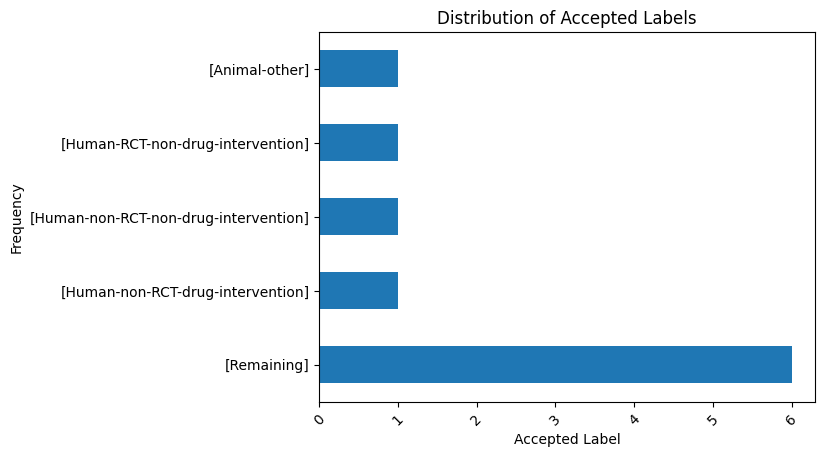

In [18]:
# Explode the 'accepted_label' column to have each label as a separate row
df_exploded = sampled_df.explode('accepted_label')

# Count the occurrences of each label
label_counts = sampled_df['accepted_label'].value_counts()

# Plot the distribution
label_counts.plot(kind='barh')
plt.title('Distribution of Accepted Labels')
plt.xlabel('Accepted Label')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [19]:
# Define a function to apply GPT queries with a progress bar
def apply_gpt_with_progress(data_series, prompt_text, model="gpt-3.5-turbo"):
    results = []
    total_items = len(data_series)
    # Create a tqdm progress bar
    with tqdm(total=total_items, desc=f"Processing dataset") as pbar:
        for text in data_series:
            result = query_gpt(text, prompt_text, model)
            results.append(result)
            pbar.update(1)  # Update the progress bar

    return results

### Run GPT

In [20]:
sampled_df['gpt_predictions'] = apply_gpt_with_progress(sampled_df['abstract'], prompt)

Processing dataset:   0%|                                                                                                           | 0/10 [00:00<?, ?it/s]

Trying to call OpenAI API...


Processing dataset:  10%|█████████▉                                                                                         | 1/10 [00:01<00:11,  1.30s/it]

Trying to call OpenAI API...


Processing dataset:  20%|███████████████████▊                                                                               | 2/10 [00:03<00:12,  1.62s/it]

Trying to call OpenAI API...


Processing dataset:  30%|█████████████████████████████▋                                                                     | 3/10 [00:04<00:11,  1.63s/it]

Trying to call OpenAI API...


Processing dataset:  40%|███████████████████████████████████████▌                                                           | 4/10 [00:06<00:09,  1.62s/it]

Trying to call OpenAI API...


Processing dataset:  50%|█████████████████████████████████████████████████▌                                                 | 5/10 [00:08<00:08,  1.64s/it]

Trying to call OpenAI API...


Processing dataset:  60%|███████████████████████████████████████████████████████████▍                                       | 6/10 [00:09<00:06,  1.71s/it]

Trying to call OpenAI API...


Processing dataset:  70%|█████████████████████████████████████████████████████████████████████▎                             | 7/10 [00:11<00:04,  1.64s/it]

Trying to call OpenAI API...


Processing dataset:  80%|███████████████████████████████████████████████████████████████████████████████▏                   | 8/10 [00:13<00:03,  1.68s/it]

Trying to call OpenAI API...


Processing dataset:  90%|█████████████████████████████████████████████████████████████████████████████████████████          | 9/10 [00:14<00:01,  1.60s/it]

Trying to call OpenAI API...


Processing dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.59s/it]


In [21]:
labels = ["Human-systematic-review", "Human-RCT-drug-intervention", "Human-RCT-non-drug-intervention", "Human-RCT-non-intervention", "Human-case-report", "Human-non-RCT-drug-intervention", "Human-non-RCT-non-drug-intervention", "Animal-systematic-review", "Animal-drug-intervention", "Animal-non-drug-intervention", "Animal-other", "Non-systematic-review", "In-vitro-study", "Clinical-study-protocol", "Remaining"]

label_to_numerical = {label: i for i, label in enumerate(labels)}
label_to_numerical["label missing"] = -1

In [22]:
label_to_numerical

{'Human-systematic-review': 0,
 'Human-RCT-drug-intervention': 1,
 'Human-RCT-non-drug-intervention': 2,
 'Human-RCT-non-intervention': 3,
 'Human-case-report': 4,
 'Human-non-RCT-drug-intervention': 5,
 'Human-non-RCT-non-drug-intervention': 6,
 'Animal-systematic-review': 7,
 'Animal-drug-intervention': 8,
 'Animal-non-drug-intervention': 9,
 'Animal-other': 10,
 'Non-systematic-review': 11,
 'In-vitro-study': 12,
 'Clinical-study-protocol': 13,
 'Remaining': 14,
 'label missing': -1}

In [23]:
df_exploded = sampled_df.explode('accepted_label')
df_exploded['gpt_label'] = df_exploded['gpt_predictions'].apply(lambda x: json.loads(x)['gpt_label'])

df_exploded.head(3)

,pmid,journal_name,title,abstract,accepted_label,gpt_predictions,gpt_label
304,12905582,Fa yi xue za zhi,[The research of the heroin and its metabolite...,Heroin can be metabolized easily in body and t...,Remaining,"{\n ""gpt_label"": ""Human-case-report"",\n ...",Human-case-report
340,28645717,Vaccine,Surveillance of pneumococcal colonization and ...,Following the introduction of pneumococcal con...,Human-non-RCT-drug-intervention,"{\n ""gpt_label"": ""Human-systematic-review"",...",Human-systematic-review
47,11482695,Acta neurochirurgica,Carotid endarterectomy: a new technique replac...,Carotid endarterectomy has been reported to in...,Human-non-RCT-non-drug-intervention,"{\n ""gpt_label"": ""Human-case-report"",\n ...",Human-case-report


### Evaluate performance

In [24]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import balanced_accuracy_score


In [25]:
# Adjust mapping to return -1 for labels not found in the map
df_exploded['accepted_label_numerical'] = df_exploded['accepted_label'].apply(lambda x: label_to_numerical.get(x, -1))
df_exploded['gpt_predictions_numerical'] = df_exploded['gpt_predictions'].apply(lambda x: label_to_numerical.get(x, -1))

In [26]:
len(labels)

15

In [27]:
# Extract arrays for evaluation
y_true = df_exploded['accepted_label_numerical'].values
y_pred = df_exploded['gpt_predictions_numerical'].values

# Evaluation
accuracy = accuracy_score(y_true, y_pred)
#report = classification_report(y_true, y_pred,output_dict=True, zero_division=0)
accuracy_balanced = balanced_accuracy_score(y_true, y_pred)

# Adjusting the classification report to only include relevant labels
unique_labels = sorted(set(y_true) | set(y_pred))
target_names_adjusted = [labels[i] for i in unique_labels]

# Recalculate classification report with adjusted target names
report_adjusted = classification_report(y_true, y_pred, output_dict=True, labels=unique_labels, target_names=target_names_adjusted, zero_division=0)

accuracy, accuracy_balanced # Note: proportion of correctly predicted observations to the total observations. It's most useful when the classes are balanced but can be misleading when dealing with imbalanced classes.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(0.0, 0.0)

In [28]:
# Convert the report to a DataFrame for visualization
report_df = pd.DataFrame(report_adjusted).transpose()

report_df

,precision,recall,f1-score,support
Remaining,0.0,0.0,0.0,6.0
Human-RCT-non-drug-intervention,0.0,0.0,0.0,1.0
Human-non-RCT-drug-intervention,0.0,0.0,0.0,1.0
Human-non-RCT-non-drug-intervention,0.0,0.0,0.0,1.0
Animal-other,0.0,0.0,0.0,1.0
accuracy,0.0,0.0,0.0,0.0
macro avg,0.0,0.0,0.0,10.0
weighted avg,0.0,0.0,0.0,10.0


In [29]:
# note: The support is the number of occurrences of each class in y_true.
report_adjusted

{'Remaining': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 6.0},
 'Human-RCT-non-drug-intervention': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 1.0},
 'Human-non-RCT-drug-intervention': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 1.0},
 'Human-non-RCT-non-drug-intervention': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 1.0},
 'Animal-other': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 1.0},
 'accuracy': 0.0,
 'macro avg': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 10.0},
 'weighted avg': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 10.0}}

# Read prompts from file and query GPT

In [30]:
json_file_path = "./prompt_strategies.json"
# Load the JSON file
with open(json_file_path, 'r') as file:
    prompts_data = json.load(file)

In [31]:
sampled_df = df.sample(n=50, random_state=1)
sampled_df = sampled_df.explode('accepted_label')
sampled_df

,pmid,journal_name,title,abstract,accepted_label
304,12905582,Fa yi xue za zhi,[The research of the heroin and its metabolite...,Heroin can be metabolized easily in body and t...,Remaining
340,28645717,Vaccine,Surveillance of pneumococcal colonization and ...,Following the introduction of pneumococcal con...,Human-non-RCT-drug-intervention
47,11482695,Acta neurochirurgica,Carotid endarterectomy: a new technique replac...,Carotid endarterectomy has been reported to in...,Human-non-RCT-non-drug-intervention
67,15065953,Journal of consulting and clinical psychology,Traditional versus integrative behavioral coup...,A randomized clinical trial compared the effec...,Human-RCT-non-drug-intervention
479,9578881,The Journal of laryngology and otology,Vocal fold abductor paralysis as a solitary an...,A patient is presented who had bilateral abduc...,Remaining
485,2115207,Scandinavian journal of infectious diseases. S...,Childhood acute bacterial meningitis in the Su...,The aims of the present study were to document...,Remaining
310,2946351,The British journal of psychiatry : the journa...,Psychiatric disorders in mildly and severely m...,A total of 149 children aged 13-17 years were ...,Remaining
31,12045804,Revista de saude publica,Assessment of a consultation-liaison psychiatr...,To investigate the relevance of subjective cri...,Remaining
249,18084303,Nature structural & molecular biology,Structural basis for synaptic adhesion mediate...,The heterophilic synaptic adhesion molecules n...,Animal-other
90,16332401,Neurobiology of aging,Increased cholesterol in Abeta-positive nerve ...,Synapse loss in Alzheimer's disease (AD) is po...,Remaining


## Run different prompts over the data

In [ ]:
prompt_ids_to_test = ["P1", "P2", "P3", "P4"]
model = "gpt-3.5-turbo"

for prompt in prompts_data["prompts"]:
    prompt_id = prompt["id"]
    prompt_text = prompt["text"]

    if prompt_id in prompt_ids_to_test:
        # Apply GPT predictions
        sampled_df[f'gpt_predictions_{prompt_id}'] = apply_gpt_with_progress(sampled_df['abstract'], prompt_text, model)
        sampled_df[f'gpt_predictions_{prompt_id}'] = sampled_df[f'gpt_predictions_{prompt_id}'].apply(lambda x: json.loads(x)['gpt_label'])
        sampled_df.to_csv(f"predictions/{model}_outputs_{'_'.join(prompt_ids_to_test)}.csv") # saving after each prompt strategy has been run, in order not to loose information in case a later strategy fails
    else:
        print(f"Skipping prompt {prompt_id}")
        

Processing dataset:   0%|                                                                                                           | 0/50 [00:00<?, ?it/s]

Trying to call OpenAI API...


Processing dataset:   2%|█▉                                                                                                 | 1/50 [00:01<00:54,  1.12s/it]

Trying to call OpenAI API...


Processing dataset:   4%|███▉                                                                                               | 2/50 [00:01<00:45,  1.06it/s]

Trying to call OpenAI API...


Processing dataset:   6%|█████▉                                                                                             | 3/50 [00:03<00:48,  1.03s/it]

Trying to call OpenAI API...


Processing dataset:   8%|███████▉                                                                                           | 4/50 [00:04<00:49,  1.07s/it]

Trying to call OpenAI API...


Processing dataset:  10%|█████████▉                                                                                         | 5/50 [01:03<16:29, 21.99s/it]

Trying to call OpenAI API...


Processing dataset:  12%|███████████▉                                                                                       | 6/50 [01:04<10:53, 14.86s/it]

Trying to call OpenAI API...


Processing dataset:  14%|█████████████▊                                                                                     | 7/50 [01:05<07:26, 10.37s/it]

Trying to call OpenAI API...


Processing dataset:  16%|███████████████▊                                                                                   | 8/50 [01:06<05:07,  7.33s/it]

Trying to call OpenAI API...


Processing dataset:  18%|█████████████████▊                                                                                 | 9/50 [01:07<03:38,  5.32s/it]

Trying to call OpenAI API...


Processing dataset:  20%|███████████████████▌                                                                              | 10/50 [01:07<02:37,  3.93s/it]

Trying to call OpenAI API...


Processing dataset:  22%|█████████████████████▌                                                                            | 11/50 [01:09<02:01,  3.11s/it]

Trying to call OpenAI API...


Processing dataset:  24%|███████████████████████▌                                                                          | 12/50 [01:09<01:30,  2.38s/it]

Trying to call OpenAI API...


Processing dataset:  26%|█████████████████████████▍                                                                        | 13/50 [01:10<01:09,  1.87s/it]

Trying to call OpenAI API...


Processing dataset:  28%|███████████████████████████▍                                                                      | 14/50 [01:11<00:54,  1.53s/it]

Trying to call OpenAI API...


Processing dataset:  30%|█████████████████████████████▍                                                                    | 15/50 [01:12<00:45,  1.31s/it]

Trying to call OpenAI API...


Processing dataset:  32%|███████████████████████████████▎                                                                  | 16/50 [01:13<00:39,  1.17s/it]

Trying to call OpenAI API...


Processing dataset:  34%|█████████████████████████████████▎                                                                | 17/50 [01:14<00:39,  1.18s/it]

Trying to call OpenAI API...


Processing dataset:  36%|███████████████████████████████████▎                                                              | 18/50 [01:15<00:35,  1.10s/it]

Trying to call OpenAI API...


Processing dataset:  38%|█████████████████████████████████████▏                                                            | 19/50 [01:15<00:30,  1.01it/s]

Trying to call OpenAI API...


Processing dataset:  40%|███████████████████████████████████████▏                                                          | 20/50 [01:16<00:27,  1.10it/s]

Trying to call OpenAI API...


Processing dataset:  42%|█████████████████████████████████████████▏                                                        | 21/50 [01:17<00:27,  1.06it/s]

Trying to call OpenAI API...


Processing dataset:  44%|███████████████████████████████████████████                                                       | 22/50 [01:18<00:25,  1.11it/s]

Trying to call OpenAI API...


Processing dataset:  46%|█████████████████████████████████████████████                                                     | 23/50 [01:19<00:24,  1.10it/s]

Trying to call OpenAI API...


Processing dataset:  48%|███████████████████████████████████████████████                                                   | 24/50 [01:21<00:30,  1.16s/it]

Trying to call OpenAI API...


Processing dataset:  50%|█████████████████████████████████████████████████                                                 | 25/50 [01:21<00:26,  1.06s/it]

Trying to call OpenAI API...


Processing dataset:  52%|██████████████████████████████████████████████████▉                                               | 26/50 [01:22<00:22,  1.05it/s]

Trying to call OpenAI API...


Processing dataset:  54%|████████████████████████████████████████████████████▉                                             | 27/50 [01:23<00:19,  1.17it/s]

Trying to call OpenAI API...


Processing dataset:  56%|██████████████████████████████████████████████████████▉                                           | 28/50 [01:24<00:19,  1.11it/s]

Trying to call OpenAI API...


Processing dataset:  58%|████████████████████████████████████████████████████████▊                                         | 29/50 [01:24<00:17,  1.18it/s]

Trying to call OpenAI API...


Processing dataset:  60%|██████████████████████████████████████████████████████████▊                                       | 30/50 [01:26<00:18,  1.07it/s]

Trying to call OpenAI API...


Processing dataset:  62%|████████████████████████████████████████████████████████████▊                                     | 31/50 [01:26<00:15,  1.20it/s]

Trying to call OpenAI API...


Processing dataset:  64%|██████████████████████████████████████████████████████████████▋                                   | 32/50 [01:27<00:14,  1.20it/s]

Trying to call OpenAI API...


Processing dataset:  66%|████████████████████████████████████████████████████████████████▋                                 | 33/50 [01:28<00:14,  1.21it/s]

Trying to call OpenAI API...


Processing dataset:  68%|██████████████████████████████████████████████████████████████████▋                               | 34/50 [01:29<00:13,  1.21it/s]

Trying to call OpenAI API...


Processing dataset:  70%|████████████████████████████████████████████████████████████████████▌                             | 35/50 [01:30<00:14,  1.04it/s]

Trying to call OpenAI API...


Processing dataset:  72%|██████████████████████████████████████████████████████████████████████▌                           | 36/50 [01:31<00:12,  1.15it/s]

Trying to call OpenAI API...


Processing dataset:  74%|████████████████████████████████████████████████████████████████████████▌                         | 37/50 [01:31<00:10,  1.23it/s]

Trying to call OpenAI API...


Processing dataset:  76%|██████████████████████████████████████████████████████████████████████████▍                       | 38/50 [01:32<00:09,  1.24it/s]

Trying to call OpenAI API...


Processing dataset:  78%|████████████████████████████████████████████████████████████████████████████▍                     | 39/50 [01:34<00:11,  1.05s/it]

Trying to call OpenAI API...


Processing dataset:  80%|██████████████████████████████████████████████████████████████████████████████▍                   | 40/50 [01:35<00:10,  1.07s/it]

Trying to call OpenAI API...


Processing dataset:  82%|████████████████████████████████████████████████████████████████████████████████▎                 | 41/50 [01:36<00:09,  1.03s/it]

Trying to call OpenAI API...


Processing dataset:  84%|██████████████████████████████████████████████████████████████████████████████████▎               | 42/50 [01:36<00:07,  1.12it/s]

Trying to call OpenAI API...


Processing dataset:  86%|████████████████████████████████████████████████████████████████████████████████████▎             | 43/50 [01:37<00:05,  1.18it/s]

Trying to call OpenAI API...


In [ ]:
sampled_df.head()

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report
import numpy as np

In [ ]:
sampled_df.head(5)

## Evaluate each prompt

In [ ]:
def map_label_to_numerical(label):
    # Check if label is a dictionary
    if isinstance(label, dict):
        # Extract the label with the highest score/probability
        highest_label = max(label, key=label.get)
        return label_to_numerical.get(highest_label, -1)
    else:
        # Directly map string labels to numerical IDs
        return label_to_numerical.get(label, -1)
        
# Convert accepted labels to numerical
sampled_df['accepted_label_numerical'] = sampled_df['accepted_label'].apply(lambda x: label_to_numerical.get(x, -1))

# Initialize a list to hold DataFrame for each report and summary statistics
report_dfs = []
summary_stats = []

# Iterate over each GPT prediction column
for prompt_id in prompt_ids_to_test:
    print("Evaluating ", prompt_id)
    prediction_col = f'gpt_predictions_{prompt_id}'
    
    # Map GPT predictions to numerical values
    sampled_df[f'{prediction_col}_numerical'] = sampled_df[prediction_col].apply(map_label_to_numerical)
    
    # Extract arrays for evaluation
    y_true = sampled_df['accepted_label_numerical'].values
    y_pred = sampled_df[f'{prediction_col}_numerical'].values
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    accuracy_balanced = balanced_accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0, labels=range(len(labels)), target_names=labels)
    
    # Create DataFrame from report
    report_df = pd.DataFrame(report).transpose()
    report_df['Prompt ID'] = prompt_id  # Add column to indicate the prompt ID
    report_dfs.append(report_df)
    
    # Extract summary statistics (average precision, recall, F1)
    summary = report_df.loc['weighted avg', ['precision', 'recall', 'f1-score']].to_dict()
    summary['Prompt ID'] = prompt_id
    summary_stats.append(summary)

# Combine all report DataFrames
all_reports_df = pd.concat(report_dfs)

# Create a summary table for average precision, recall, and F1-score
summary_df = pd.DataFrame(summary_stats)

In [ ]:
summary_df

In [ ]:
all_reports_df.to_csv(f"evaluations/{model}_per_class_{'_'.join(prompt_ids_to_test)}.csv") # saving after each prompt strategy has been run, in order not to loose information in case a later strategy fails
summary_df.to_csv(f"evaluations/{model}_summary_{'_'.join(prompt_ids_to_test)}.csv") # saving after each prompt strategy has been run, in order not to loose information in case a later strategy fails


In [ ]:
all_reports_df